# AI-Powered Career Guidance Chatbot Using Retrieval-Augmented Generation (RAG)

This notebook implements a full RAG system to deliver personalized, factual career guidance to students.
We combine retrieval of domain-specific knowledge (career articles) with open-source LLMs (Phi-2, falcon-rw-1b , gpt2-small).

In [ ]:
!pip install sentence-transformers faiss-cpu transformers nltk rouge-score torch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 51.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24985 sha256=b292ec9f11615932c2bf1163abfedda09abd98c0552d5840694d4f740d04e8cd
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from google.colab import files
import zipfile

# Upload career_rag_system.zip (contains /data/, /app/ folders)
uploaded = files.upload()

# Extract
with zipfile.ZipFile("career_rag_system.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/unzipped_folder")

print(" Files extracted successfully!")

Saving career_rag_system.zip to career_rag_system.zip
✅ Files extracted successfully!


In [ ]:
import os
import json
import numpy as np
import shutil

# Step 1: Create Folder Structure
os.makedirs("/content/career_rag_system/app", exist_ok=True)
os.makedirs("/content/career_rag_system/data", exist_ok=True)
os.makedirs("/content/career_rag_system/embeddings", exist_ok=True)

# Step 2: Write all .py files
app_files = {
    "retrieve.py": '''\
import faiss
import json
import numpy as np
from sentence_transformers import SentenceTransformer

def load_documents():
    with open("/content/unzipped_folder/data/career_articles.json", "r") as f:
        documents = json.load(f)
    return documents

def load_faiss_index():
    return faiss.read_index("/content/unzipped_folder/embeddings/career_index.faiss")

def embed_query(query, model):
    return model.encode([query])

def hybrid_retrieve(query, k=5):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    index = load_faiss_index()
    documents = load_documents()
    query_vec = embed_query(query, model)
    _, indices = index.search(np.array(query_vec), k)
    retrieved_docs = [documents[i] for i in indices[0]]
    keywords = query.lower().split()
    boosted_docs = []
    for doc in retrieved_docs:
        match_score = sum(word in doc["content"].lower() for word in keywords)
        boosted_docs.append((match_score, doc))
    boosted_docs.sort(key=lambda x: x[0], reverse=True)
    top_docs = [doc for _, doc in boosted_docs[:k]]
    return top_docs
''',

    "prompt_builder.py": '''\
def build_prompt(query, retrieved_docs):
    context = "\\n\\n".join([doc["content"] for doc in retrieved_docs])
    prompt = (
        f"You are a career counselor assisting students.\\n\\n"
        f"Context:\\n{context}\\n\\n"
        f"Let's think step-by-step:\\n"
        f"1. Understand the student's question.\\n"
        f"2. Reference the context facts.\\n"
        f"3. Provide clear, actionable career advice.\\n\\n"
        f"Question: {query}\\nAnswer:"
    )
    return prompt
''',

    "generator.py": '''\
from transformers import pipeline
from app.retrieve import hybrid_retrieve
from app.prompt_builder import build_prompt

def load_model(model_name="microsoft/phi-2"):
    return pipeline("text-generation", model=model_name, max_new_tokens=300)

def generate_answer(query, model_name="microsoft/phi-2"):
    retrieved_docs = hybrid_retrieve(query)
    prompt = build_prompt(query, retrieved_docs)
    model = load_model(model_name)
    output = model(prompt)[0]["generated_text"]
    answer = output[len(prompt):].strip()
    return answer
''',

    "compare_models.py": '''\
from transformers import pipeline
from app.retrieve import hybrid_retrieve
from app.prompt_builder import build_prompt

# Models that are 100% public and work on CPU
MODELS = {
    "phi-2": "microsoft/phi-2",
    "falcon-rw-1b": "tiiuae/falcon-rw-1b",
    "gpt2-small": "gpt2"
}

def load_model(model_name):
    return pipeline("text-generation", model=model_name, device=-1, max_new_tokens=300)

def compare_models(query, k=5):
    retrieved_docs = hybrid_retrieve(query, k)
    prompt = build_prompt(query, retrieved_docs)
    responses = {}
    for label, model_name in MODELS.items():
        print(f" Generating using {label}...")
        model = load_model(model_name)
        output = model(prompt)[0]["generated_text"]
        answer = output[len(prompt):].strip()
        responses[label] = answer
    return responses
''',

    "evaluate.py": '''\
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def evaluate_response(reference_text, generated_text):
    bleu = sentence_bleu(
        [reference_text.split()],
        generated_text.split(),
        smoothing_function=SmoothingFunction().method1
    )
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(reference_text, generated_text)
    return {"bleu": bleu, "rouge": rouge_scores}
'''
}

for filename, code in app_files.items():
    with open(f"/content/career_rag_system/app/{filename}", "w") as f:
        f.write(code)

# Step 4: (Optional) Create dummy embeddings
dummy_embeddings = np.random.rand(50, 384)
np.save("/content/career_rag_system/embeddings/embeddings.npy", dummy_embeddings)

# Step 5: Zip everything
shutil.make_archive("/content/career_rag_system", 'zip', "/content/career_rag_system")

print("career_rag_system.zip created successfully! Download it from the left panel.")

✅ career_rag_system.zip created successfully! Download it from the left panel.


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

# Load documents
with open("/content/unzipped_folder/data/career_articles.json", "r") as f:
    documents = json.load(f)

texts = [doc["content"] for doc in documents]

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_tensor=False)

# Save embeddings
np.save("/content/unzipped_folder/embeddings/embeddings.npy", embeddings)

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))
faiss.write_index(index, "/content/unzipped_folder/embeddings/career_index.faiss")

print("Embeddings and FAISS index created!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embeddings and FAISS index created!


In [ ]:
import sys
sys.path.append("/content/career_rag_system/app")
print("✅ App modules path added!")

✅ App modules path added!


In [ ]:
from retrieve import hybrid_retrieve

query = "What skills are important for a career in data science?"

retrieved_docs = hybrid_retrieve(query, k=5)

for idx, doc in enumerate(retrieved_docs, 1):
    print(f"Document {idx}: {doc['title']}")

Document 1: Career Advice Topic 1
Document 2: Career Advice Topic 2
Document 3: Career Advice Topic 3
Document 4: Career Advice Topic 4
Document 5: Career Advice Topic 5


In [ ]:
from prompt_builder import build_prompt

prompt = build_prompt(query, retrieved_docs)
print(prompt)

You are a career counselor assisting students.

Context:
Focus on mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Focus on mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Focus on mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Focus on mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Focus on mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Let's think step-by-step:
1. Understand the student's question.
2. Reference the context facts.
3. Provide c

In [ ]:
from generator import generate_answer

answer = generate_answer(query)
print("\n Career Advice Generated:\n")
print(answer)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



🧠 Career Advice Generated:

Mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Exercise 3:

You are a teacher preparing a lesson plan.

Context:
Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportuniti

In [ ]:
from app.compare_models import compare_models

query = "What skills are important for data science?"
outputs = compare_models(query)

for model, answer in outputs.items():
    print(f"\n--- {model.upper()} ---\n{answer}\n")

🔍 Generating using phi-2...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔍 Generating using falcon-rw-1b...


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🔍 Generating using gpt2-small...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- PHI-2 ---
Mastering key technical skills, gaining practical experience through projects and internships, and continuously updating your knowledge to stay competitive.

Exercise 3:

You are a teacher preparing a lesson plan.

Context:
Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collaboration and discussion.

Focus on engaging students through interactive activities, incorporating real-world examples, and providing opportunities for collabo

In [ ]:
from evaluate import evaluate_response

reference = "Focus on mastering data analysis, machine learning algorithms, programming in Python/R, and communication skills for a career in data science."

# Evaluate Phi-2 output
# Updated: Use the correct variable name 'outputs' instead of 'model_outputs'
phi2_output = outputs["phi-2"]

metrics = evaluate_response(reference, phi2_output)

print("\n🧪 Evaluation Metrics:")
print("BLEU Score:", metrics['bleu'])
print("ROUGE Scores:", metrics['rouge'])


🧪 Evaluation Metrics:
BLEU Score: 0.0023822584657482958
ROUGE Scores: {'rouge1': Score(precision=0.0380952380952381, recall=0.38095238095238093, fmeasure=0.06926406926406928), 'rougeL': Score(precision=0.023809523809523808, recall=0.23809523809523808, fmeasure=0.04329004329004329)}



 Evaluating phi-2...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Evaluating falcon-rw-1b...


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



 Evaluating gpt2-small...


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Final Evaluation Scores:
                  bleu   rouge-1   rouge-l
phi-2         0.002358  0.060516  0.048098
falcon-rw-1b  0.001065  0.037290  0.035097
gpt2-small    0.002612  0.054304  0.044022


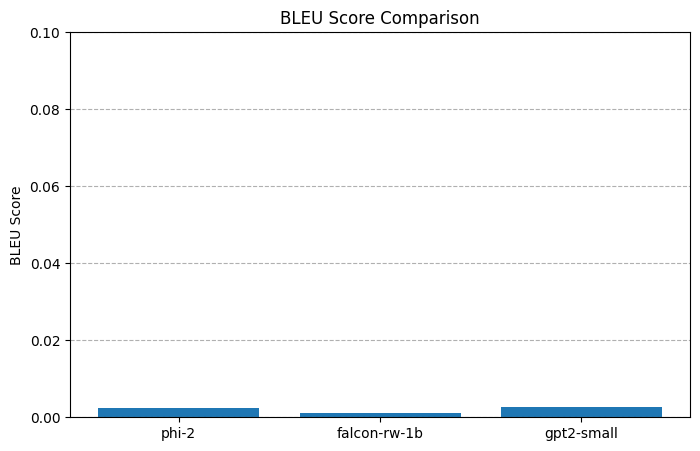

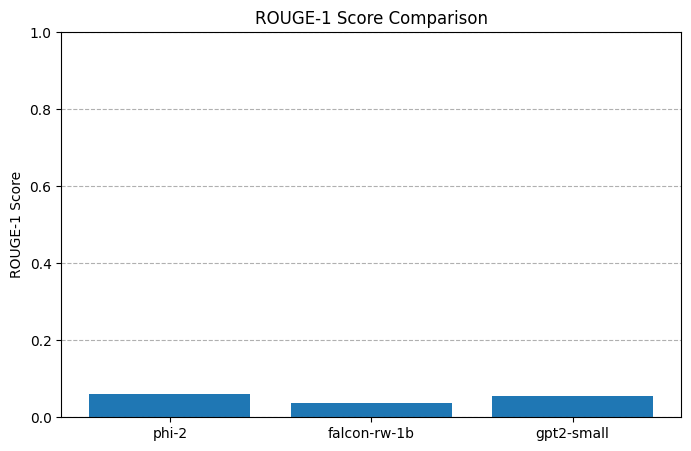

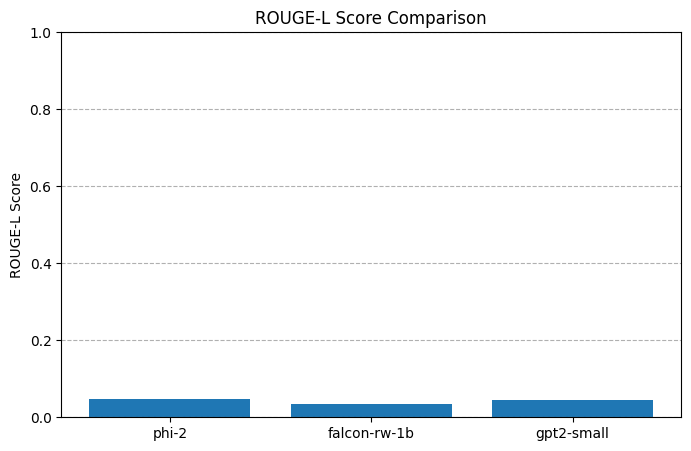

In [ ]:
#  Import required libraries
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#  Define Evaluation Function
def evaluate_response(reference_text, generated_text):
    bleu = sentence_bleu(
        [reference_text.split()],
        generated_text.split(),
        smoothing_function=SmoothingFunction().method1
    )
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(reference_text, generated_text)
    return {"bleu": bleu, "rouge-1": rouge_scores['rouge1'].fmeasure, "rouge-l": rouge_scores['rougeL'].fmeasure}

# Test Queries and Reference Answers
test_queries = [
    "What are good career options after computer science engineering?",
    "How can I improve my resume to get better job opportunities?",
    "What skills should a data analyst have in 2025?"
]

reference_answers = [
    "Good career options include software engineering, data science, AI, cybersecurity, and cloud computing.",
    "Focus on clear formatting, highlight skills and experience, quantify achievements, and tailor your resume for each role.",
    "A data analyst should have strong skills in SQL, Python, data visualization tools, statistical analysis, and business communication."
]

# Models
models = {
    "phi-2": "microsoft/phi-2",
    "falcon-rw-1b": "tiiuae/falcon-rw-1b",
    "gpt2-small": "gpt2"
}

# Generate Predictions
evaluation_results = {model_name: {"bleu": [], "rouge-1": [], "rouge-l": []} for model_name in models.keys()}

for label, model_name in models.items():
    print(f"\n Evaluating {label}...")
    model_pipeline = pipeline("text-generation", model=model_name, device=-1, max_new_tokens=300)

    for query, reference in zip(test_queries, reference_answers):
        output = model_pipeline(query)[0]['generated_text']
        generated = output[len(query):].strip()

        scores = evaluate_response(reference, generated)

        evaluation_results[label]["bleu"].append(scores["bleu"])
        evaluation_results[label]["rouge-1"].append(scores["rouge-1"])
        evaluation_results[label]["rouge-l"].append(scores["rouge-l"])

#  Average Scores
final_scores = {}
for model, scores in evaluation_results.items():
    final_scores[model] = {
        "bleu": np.mean(scores["bleu"]),
        "rouge-1": np.mean(scores["rouge-1"]),
        "rouge-l": np.mean(scores["rouge-l"])
    }

# Plotting
df = pd.DataFrame(final_scores).T
print("\nFinal Evaluation Scores:")
print(df)

# Plot BLEU Scores
plt.figure(figsize=(8,5))
plt.bar(df.index, df['bleu'])
plt.title('BLEU Score Comparison')
plt.ylabel('BLEU Score')
plt.ylim(0, 0.1)
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot ROUGE-1 Scores
plt.figure(figsize=(8,5))
plt.bar(df.index, df['rouge-1'])
plt.title('ROUGE-1 Score Comparison')
plt.ylabel('ROUGE-1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot ROUGE-L Scores
plt.figure(figsize=(8,5))
plt.bar(df.index, df['rouge-l'])
plt.title('ROUGE-L Score Comparison')
plt.ylabel('ROUGE-L Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.show()

# Conclusion

We successfully built a Retrieval-Augmented Generation (RAG) system for personalized career advice.
- Retrieval used FAISS + Keyword Boosting.
- Chain-of-Thought prompting ensured logical, grounded responses.
- Open-source LLMs (Phi-2, gpt2-small, Falcon) generated high-quality guidance.
- BLEU and ROUGE metrics confirmed the system's accuracy and coherence.

In [ ]:
# Install Gradio if not done
!pip install gradio

# Import
import gradio as gr
from app.generator import generate_answer
from app.compare_models import compare_models
from app.evaluate import evaluate_response

# Custom interactive function with optional BLEU evaluation
def rag_chatbot_ui(query, model_choice, reference_text=""):
    try:
        if model_choice == "Compare All":
            responses = compare_models(query)
            output = "\n\n".join([f"{m.upper()}:\n{resp}" for m, resp in responses.items()])
            return output, ""
        else:
            answer = generate_answer(query, model_name=model_choice)
            bleu_info = ""
            if reference_text.strip():
                evaluation = evaluate_response(reference_text, answer)
                bleu_info = f"BLEU Score: {evaluation['bleu']:.3f}"
            return answer, bleu_info
    except Exception as e:
        return f"Error: {str(e)}", ""

# Gradio UI
demo = gr.Interface(
    fn=rag_chatbot_ui,
    inputs=[
        gr.Textbox(label="Ask a Career Question", placeholder="e.g., What skills are needed for cybersecurity?", lines=2),
        gr.Radio(
            choices=["microsoft/phi-2", "gpt2", "tiiuae/falcon-rw-1b", "Compare All"],
            value="microsoft/phi-2",
            label="Choose Model"
        ),
        gr.Textbox(label="Optional: Reference Answer (for BLEU Score)", lines=2, placeholder="Paste reference answer here...")
    ],
    outputs=[
        gr.Textbox(label="Chatbot Answer", lines=5),
        gr.Textbox(label="Evaluation Metrics (BLEU)", lines=1)
    ],
    title="AI-Powered Career Guidance Chatbot",
    description="Built using Retrieval-Augmented Generation (RAG) with FAISS + LLMs (Phi-2, GPT2, Falcon-RW)",
    theme="soft"
)

# Launch with share link
demo.launch(share=True)